This notebook replicates a subset of figures in Chen et al., (2017). **"A Map of Anticipatory Activity in Mouse Motor Cortex"**  


Publication link: https://www.cell.com/neuron/fulltext/S0896-6273(17)30406-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627317304063%3Fshowall%3Dtrue
  
This study characterized selectivity of cells in anterior lateral motor cortex (ALM) and medial motor cortex (MM). Cells are classified into 5 types: lick direction cells (lick), object location cells (lick), outcome cells (outcome), complex selective cells that are selective to multiple features, and non selective cells.   

In this notebook, we will introduce the relevant part of the data pipeline for the imaging experiments and how to replicate the figures from the pipeline. In particular, we will replicate Figure 4, 5 and 6.  

Figure 4 and 5 shows example cells that are selective to different features.  
Figure 6 shows the spatial distribution across the brain of the selectivity cells to different features.

In [111]:
%matplotlib notebook

In [1]:
import datajoint as dj
from pipeline import lab, experiment, imaging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Connecting shan@host.docker.internal:3306


# Architecture of the data pipeline

Here, we introduced the architecture of the data pipeline created and maintained with DataJoint. This pipeline is mainly composed of three schemas:  

1. `lab`: tables for meta information, including subjects and their genetic information, actions on the subjects and device information.  
2. `experiment`: tables for behavioral information.  
3. `imaging`: tables for two-photon image recording.


## Diagram of schema `lab`

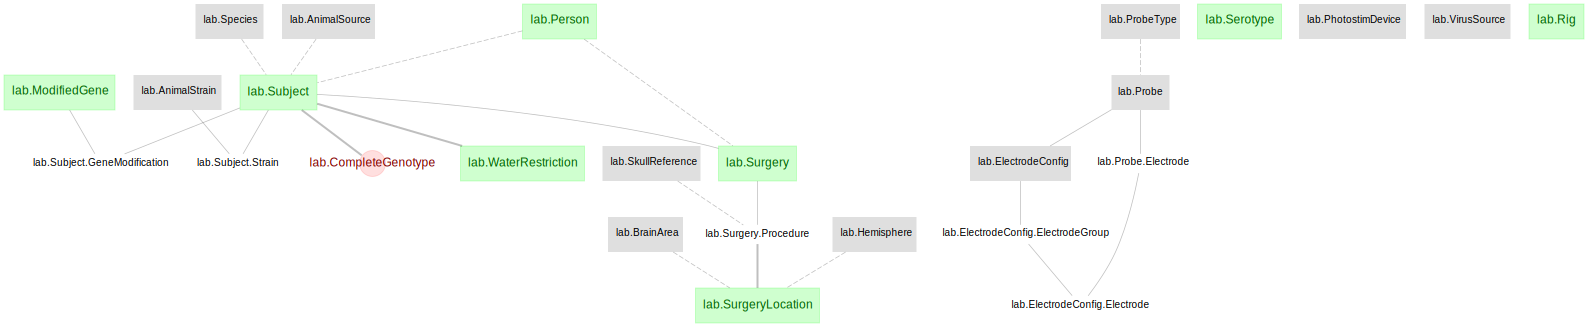

In [315]:
dj.Diagram(lab)

One of the most important tables in this schema is `lab.Subject`, with the following table definition. The primary key that uniquely identifies a subject is the `subject_nickname`.

In [317]:
lab.Subject.describe();

subject_nickname     : varchar(32)                  # name used in the filename
---
-> [nullable] lab.Person
cage_number=null     : int                          # institution 6 digit animal ID
date_of_birth=null   : date                         # format: yyyy-mm-dd
sex                  : enum('M','F','Unknown')      
-> lab.Species
-> [nullable] lab.AnimalSource



Table contents of lab.Subject:

In [318]:
lab.Subject()

subject_nickname name used in the filename,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,species,animal_source
an041,Tsai-Wen Chen,None,None,M,Mus musculus,Jackson Labs
an043,Tsai-Wen Chen,None,None,M,Mus musculus,Jackson Labs
an044,Tsai-Wen Chen,None,None,M,Mus musculus,Jackson Labs
an063,Tsai-Wen Chen,None,None,M,Mus musculus,Jackson Labs
an064,Tsai-Wen Chen,None,None,M,Mus musculus,Jackson Labs
an066,Tsai-Wen Chen,None,None,M,Mus musculus,Jackson Labs


Six animals have been involved in the imaging experiments in this study.

## Diagram of schema `experiment`

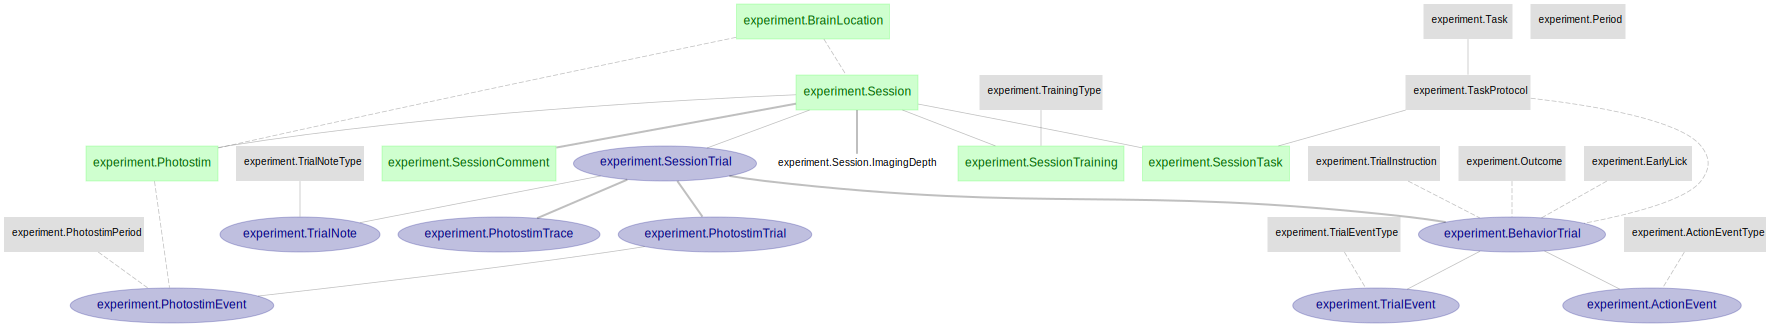

In [320]:
dj.Diagram(experiment)

### Session information

Session information is saved in the table `experiment.Session`:

In [322]:
experiment.Session.describe();

-> lab.Subject
session              : smallint                     # session number
---
session_date         : date                         
fov=1                : tinyint                      # field of view number
-> experiment.BrainLocation
-> lab.Person
-> [nullable] lab.Rig



The `experiment.Session` table depends on `lab.Subject`, and inherits the primary key of the subject, `subject_nickname`. In addition to that, a session performed on a subject is further identified by the session number `session`.  

As an example, here are the sessions performed on subject `an041`.

In [324]:
experiment.Session & 'subject_nickname="an041"'

subject_nickname name used in the filename,session session number,session_date,fov field of view number,brain_location_name unique name of this brain location (could be hash of the non-primary attr),username,rig
an041,1,2014-08-26,1,left_alm,Tsai-Wen Chen,None
an041,2,2014-08-23,1,left_alm,Tsai-Wen Chen,None
an041,3,2014-08-27,1,left_vm1,Tsai-Wen Chen,None
an041,4,2014-08-25,1,left_alm,Tsai-Wen Chen,None
an041,5,2014-08-25,1,left_alm,Tsai-Wen Chen,None
an041,6,2014-09-03,1,left_vm1,Tsai-Wen Chen,None
an041,7,2014-08-27,1,left_vm1,Tsai-Wen Chen,None
an041,8,2014-09-03,1,left_vm1,Tsai-Wen Chen,None
an041,9,2014-08-21,1,left_vm1,Tsai-Wen Chen,None
an041,10,2014-08-27,1,left_vm1,Tsai-Wen Chen,None


### Trial information

The general trial information is saved in the table `experiment.SessionTrial`:

In [327]:
experiment.SessionTrial.describe();

-> experiment.Session
trial                : smallint                     # trial number
---
trial_uid=null       : int                          # unique across sessions/animals
start_time           : decimal(8,4)                 # (s) relative to session beginning
stop_time=null       : decimal(8,4)                 # (s) relative to session beginning



The behavioral related information is further specified in the the table `experiment.BehavioralTrial`

In [329]:
experiment.BehaviorTrial.describe();

-> experiment.SessionTrial
---
-> experiment.TaskProtocol
-> experiment.TrialInstruction
-> experiment.EarlyLick
-> experiment.Outcome



This table saved information of the different features a trial including:  

1. TaskProtocol: in this paper, all trials are from a task of high tone vs. low tone of auto_delay  
  
2. TrialInstruction: instructions given to the subject, "left", "right" or "non-performing"
  
3. Outcome: subject response of this trial 

    a. "hit": correct when instructed "left" or "right"  
    b. "miss": incorrect when instructed "left" or "right"   
    c. "ignore": did not respond when instructed "left" or "right"  
    d. "non-performing": the animal follow the instruction "non-performing"
      
4. EarlyLick:   
    a. "early":  early lick during sample and/or delay  
    b. "early, presample only": early lick in the presample period, after the onset of the scheduled wave but before the sample period  
    c. "no early"

Another important aspect of the trials is the time marks for the trial events ("delay", "go" and "sample"), saved in the table `experiment.TrialEvent`:

In [331]:
experiment.TrialEvent.describe();

-> experiment.BehaviorTrial
trial_event_id       : smallint                     
---
-> experiment.TrialEventType
trial_event_time     : decimal(8,4)                 # (s) from trial start, not session start
duration=null        : decimal(8,4)                 # (s)



In [332]:
experiment.TrialEvent()

subject_nickname name used in the filename,session session number,trial trial number,trial_event_id,trial_event_type,"trial_event_time (s) from trial start, not session start",duration (s)
an041,1,1,1,sample,0.6230,None
an041,1,1,2,delay,1.8230,None
an041,1,1,3,go,4.8228,None
an041,1,2,4,sample,0.6230,None
an041,1,2,5,delay,1.8230,None
an041,1,2,6,go,5.1506,None
an041,1,3,7,sample,0.6230,None
an041,1,3,8,delay,1.8230,None
an041,1,3,9,go,4.8235,None
an041,1,4,10,sample,0.6230,None


## Diagram of schema `imaging`

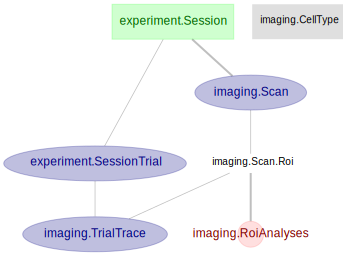

In [333]:
dj.Diagram(imaging) - 1

### ROI and Trace information

ROI segmentation and trace information are saved in `imaging.Scan.Roi`:

In [334]:
imaging.Scan.Roi.describe();

-> imaging.Scan
roi_idx              : int                          
---
cell_type            : varchar(32)                  
roi_trace            : longblob                     # average fluorescence of roi obj-timeSeriesArrayHash-value(1, 1)-valueMatrix
neuropil_trace       : longblob                     # average fluorescence of neuopil surounding each ROI, obj-timeSeriesArrayHash-value(1, 1)-valueMatrix
roi_pixel_list       : longblob                     # pixel list of this roi
ap_position          : float                        # in um, relative to bregma
ml_position          : float                        # in um, relative to bregma
inc                  : tinyint                      # whether included (criteria - cells > 1.05 times brighter than neuropil)



To facilitate analyses, we also cut the traces into different trials and save the information in the table `imaging.TrialTrace`:

In [336]:
imaging.TrialTrace.describe();

-> imaging.Scan.Roi
-> experiment.SessionTrial
---
original_time        : longblob                     # original time cut for this trial
aligned_time         : longblob                     # 0 is go cue time
aligned_trace        : longblob                     # aligned trace relative to the go cue time
dff                  : longblob                     # dff, normalized with f[0:6]



Following the paper, we performed anova test on the selectivity of the cells of different experimental features, by building a linear model:  

Basically, the dF/F0 at time point t is modeled as `dff(t) = C(pole)+C(lick)+C(outcome)+intercept+noise`

We saved the pre-computed results of p values of different features and the fit coefficient in the table `imaging.RoiAnalyses`:

In [339]:
imaging.RoiAnalyses.describe();

-> imaging.Scan.Roi
---
panova               : longblob                     # matrix of nFrames x 4, p values of alpha, beta, gamma and incerpt
alpha                : longblob                     # vector with length nFrames, coefficient of instruction
beta                 : longblob                     # vector with length nFrames, coefficient of lick
gamma                : longblob                     # vector with length nFrames, coefficient of outcome
mu                   : longblob                     # vector with length nFrames, coefficient of intercept



# Figure Replication  

Now let's replicate the Figure 4, 5 and 6 by fetching data from the data pipeline.

## Some helper functions

In [340]:
def compute_mean_sem(traces):
    return np.mean(traces, axis=0), np.std(traces, axis=0)/np.sqrt(len(traces))

def get_event_time(cell):
    events = experiment.TrialEvent & (imaging.TrialTrace & cell)
    sample = np.mean((events & 'trial_event_type = "sample"').fetch('trial_event_time'))
    delay = np.mean((events & 'trial_event_type = "delay"').fetch('trial_event_time'))
    go = np.mean((events & 'trial_event_type = "go"').fetch('trial_event_time'))
    # aligned time markers
    sample = float(sample - go)
    delay = float(delay - go)
    return [sample, delay, 0]

def get_event_idx(event_times, time):
    if len(event_times) == 1:
        return np.abs(time - event_times).argmin()
    else:
        return [np.abs(time - e).argmin() for e in event_times]

# Figures 4 and 5

Figures 4 and 5 shows example cells with different selectivities. This function plots for each cell of:

**Top**: the aligned calcium activity over time of each individual trials  
**Bottom**: the average calcium trace across trials as a function of time relative to the go cue time  

**Blue**: left instruction, correct trials  
**Red**: right instruction, correct trials  
**Light blue**: right instruction, error trials  
**Light red**: left instruction, error trials

**Dotted vertical lines**: the sample and delay epochs

In [295]:
def plot_example_cell(cell, ax0, ax1, show_ylabel):
    x1 = -6
    x2 = -5
    time_left, traces_left_correct = ((imaging.TrialTrace & cell) &
        (experiment.BehaviorTrial & 'trial_instruction="left"' & 'outcome="hit"')).fetch(
            'aligned_time', 'dff')
    traces_right_correct = ((imaging.TrialTrace & cell) &
        (experiment.BehaviorTrial & 'trial_instruction="right"' & 'outcome="hit"')).fetch(
            'dff')
    traces_left_error = ((imaging.TrialTrace & cell) &
        (experiment.BehaviorTrial & 'trial_instruction="left"' & 'outcome="miss"')).fetch(
            'dff')
    traces_right_error = ((imaging.TrialTrace & cell) &
        (experiment.BehaviorTrial & 'trial_instruction="right"' & 'outcome="miss"')).fetch(
            'dff')
    traces_left_correct = [trace for trace in traces_left_correct if len(trace)]
    traces_right_correct = [trace for trace in traces_right_correct if len(trace)]
    traces_left_error = [trace for trace in traces_left_error if len(trace)]
    traces_right_error = [trace for trace in traces_right_error if len(trace)]
    time = time_left[1]
    # plot heat map
    sns.heatmap(traces_right_correct+traces_left_correct+traces_right_error+traces_left_error, 
                cmap='gray', cbar=None, ax=ax0)
    left_correct_range = [0, len(traces_left_correct)]
    right_correct_range = [left_correct_range[1], left_correct_range[1] + len(traces_right_correct)]
    right_error_range = [right_correct_range[1], right_correct_range[1] + len(traces_right_error)]
    left_error_range = [right_error_range[1], right_error_range[1] + len(traces_left_error)]
    
    ax0.fill_betweenx(left_correct_range, x1, x2, color='blue')
    ax0.fill_betweenx(right_correct_range, x1, x2, color='red')
    ax0.fill_betweenx(right_error_range, x1, x2, color='lightblue')
    ax0.fill_betweenx(left_error_range, x1, x2, color='pink')

    # mark event time points
    event_times = get_event_time(cell)
    for idx in get_event_idx(event_times, time):
        ax0.axvline(x=idx, linestyle='--', color='white')

    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_xlim((x1, ax0.get_xlim()[1]))

    # mean df/f
    mean_left_correct, sem_left_correct = compute_mean_sem(traces_left_correct)
    mean_right_correct, sem_right_correct = compute_mean_sem(traces_right_correct)
    mean_left_error, sem_left_error = compute_mean_sem(traces_left_error)
    mean_right_error, sem_right_error = compute_mean_sem(traces_right_error)
    x = range(0, len(mean_right_correct))
    ax1.plot(x, mean_right_correct, color='blue')
    ax1.plot(x, mean_left_correct, color='red')
    ax1.plot(x, mean_left_error, color='red', alpha=0.2)
    ax1.plot(x, mean_right_error, color='blue', alpha=0.2)
    
    if show_ylabel:
        ax1.set_ylabel('dF/F0')
    ax1.set_xlabel('Time (s)')
    xticks = get_event_idx([-4.2, -3, 0], time)
    ax1.set_xticks(ticks=xticks)
    labels=['-4.2', '-3', '0']
    ax1.set_xticklabels(labels)

    # mark event time points
    for idx in get_event_idx(event_times, time):
        ax1.axvline(x=idx, linestyle='--', color='black')


## Figure 4a

This figure shows three examples of lick direction cells:  

**Left**: responsive during delay period  
**Middle**: responsive at early stage of the response period  
**Right**: reponseive at late stage of the response period

<IPython.core.display.Javascript object>


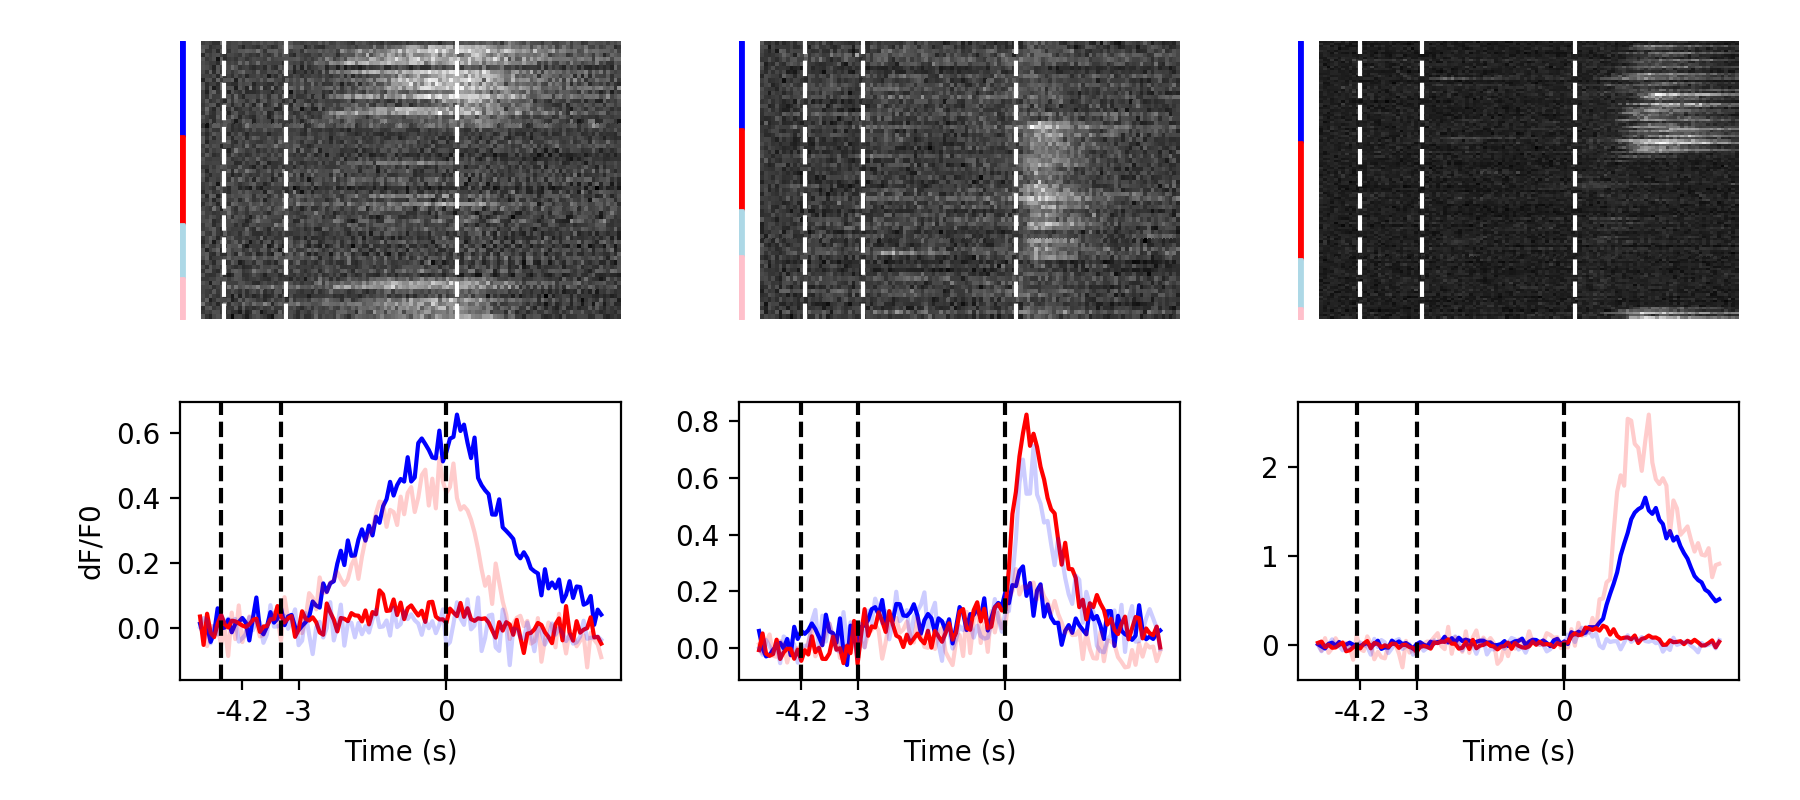

In [300]:
fig4a, axs = plt.subplots(2, 3, figsize = [9, 4])
fig4a.tight_layout()
fig4a.subplots_adjust(left=0.1, bottom=0.15)
example_cells = [
    {'subject_nickname': 'an063', 'session': 20, 'roi_idx': 24}, # idx 7667, A, left
    {'subject_nickname': 'an064', 'session': 11, 'roi_idx': 43}, # idx 10920, A, middle
    {'subject_nickname': 'an041', 'session': 14, 'roi_idx': 20}, # idx 983, A, right
]
for i, show_ylabel in zip([0, 1, 2], [True, False, False]):
    plot_example_cell(example_cells[i], axs[0, i], axs[1, i], show_ylabel=show_ylabel)


# Figure 4b

This figure shows three examples of object location cells:  

**Left**: responsive during sample period  
**Middle**: responsive during both sample and delay period  
**Right**: reponseive at late stage of the delay period

<IPython.core.display.Javascript object>


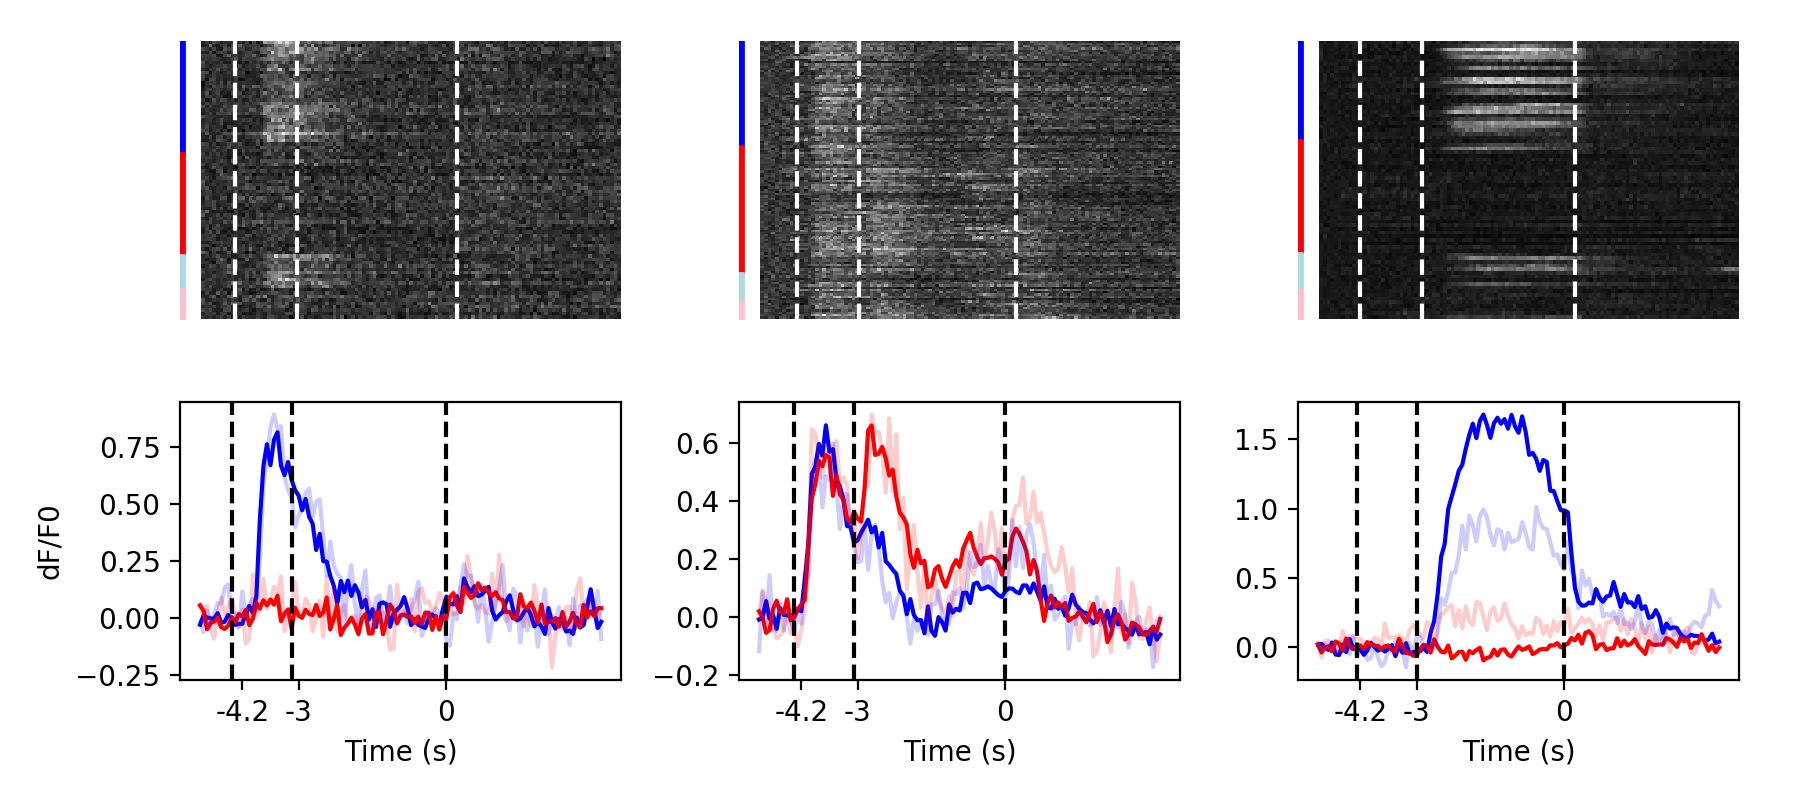

In [344]:
fig4b, axs = plt.subplots(2, 3, figsize = [9, 4])
fig4b.tight_layout()
fig4b.subplots_adjust(left=0.1, bottom=0.15)
example_cells = [
    {'subject_nickname': 'an041', 'session': 9, 'roi_idx': 88}, # idx 279, B, left
    {'subject_nickname': 'an044', 'session': 4, 'roi_idx': 29}, # idx 6485, B, Mid
    {'subject_nickname': 'an041', 'session': 4, 'roi_idx': 14}, # idx 1272, B, right
]
for i, show_ylabel in zip([0, 1, 2], [True, False, False]):
    plot_example_cell(example_cells[i], axs[0, i], axs[1, i], show_ylabel=show_ylabel)

## Figure 4c

This figure shows three examples of outcome cells:  

**Left**: responsive on correct trials   
**Middle**: responsive on error trials    
**Right**: reponseive on error trials

<IPython.core.display.Javascript object>


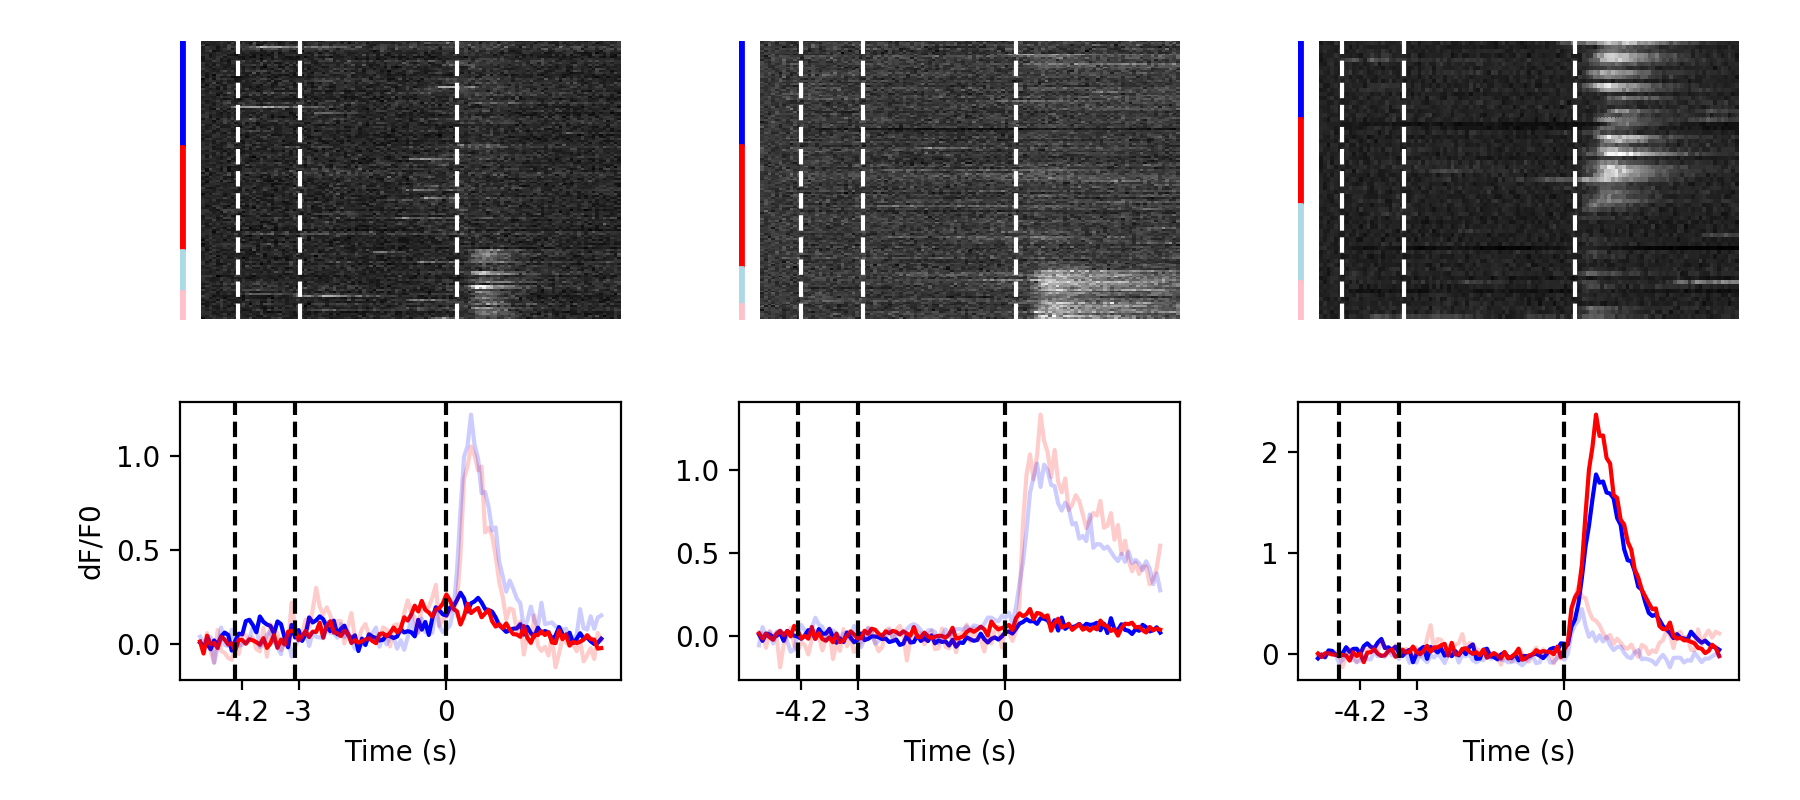

In [303]:
fig4c, axs = plt.subplots(2, 3, figsize = [9, 4])
fig4c.tight_layout()
fig4c.subplots_adjust(left=0.1, bottom=0.15)
example_cells = [
    {'subject_nickname': 'an041', 'session': 12, 'roi_idx': 42}, # idx 1901, C, left
    {'subject_nickname': 'an063', 'session': 16, 'roi_idx': 3}, # idx 7896, C, mid
    {'subject_nickname': 'an063', 'session': 18, 'roi_idx': 7}, # idx 7342, C, right
]
for i, show_ylabel in zip([0, 1, 2], [True, False, False]):
    plot_example_cell(example_cells[i], axs[0, i], axs[1, i], show_ylabel=show_ylabel)

## Figure 5a

Four example neurons with mixed selectivity that responded mainly during one specific trial type. 

<IPython.core.display.Javascript object>


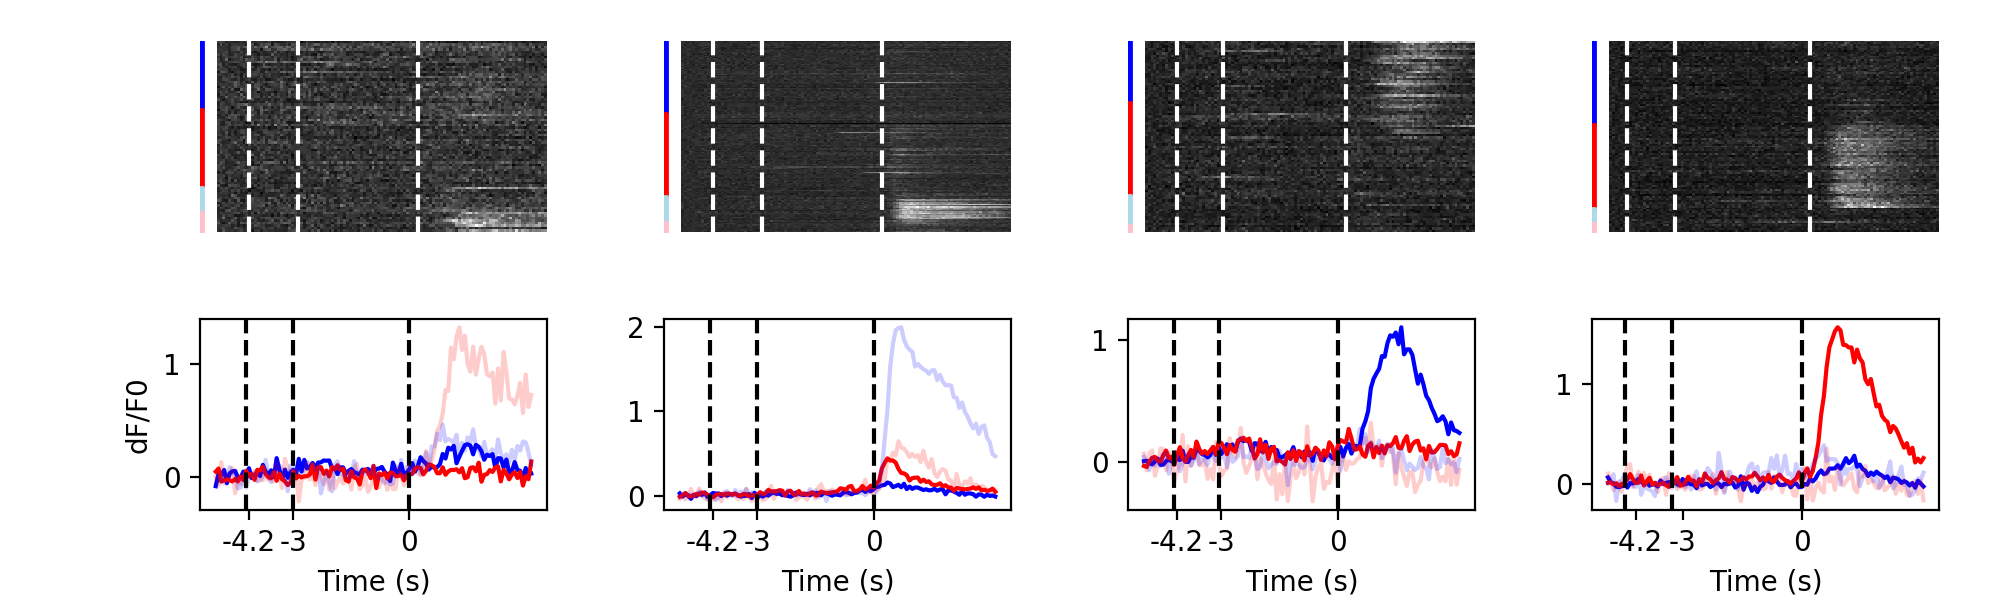

In [307]:
fig5a, axs = plt.subplots(2, 4, figsize = [10, 3])
fig5a.tight_layout()
fig5a.subplots_adjust(left=0.1, bottom=0.15)
example_cells = [
    {'subject_nickname': 'an041', 'session': 4, 'roi_idx': 146}, # idx 1404, 5A, 1
    {'subject_nickname': 'an063', 'session': 16, 'roi_idx': 34}, # idx 7927, 5A, 2, if not session 16
    {'subject_nickname': 'an041', 'session': 2, 'roi_idx': 50}, # idx 50, 5A, 3
    {'subject_nickname': 'an044', 'session': 14, 'roi_idx': 16}, # idx 4471, 5A, 4
]
for i, show_ylabel in zip([0, 1, 2, 3], [True, False, False, False]):
    plot_example_cell(example_cells[i], axs[0, i], axs[1, i], show_ylabel=show_ylabel)

## Figure 5b

 Example neurons that switched the modality of selectivity during the trial

<IPython.core.display.Javascript object>


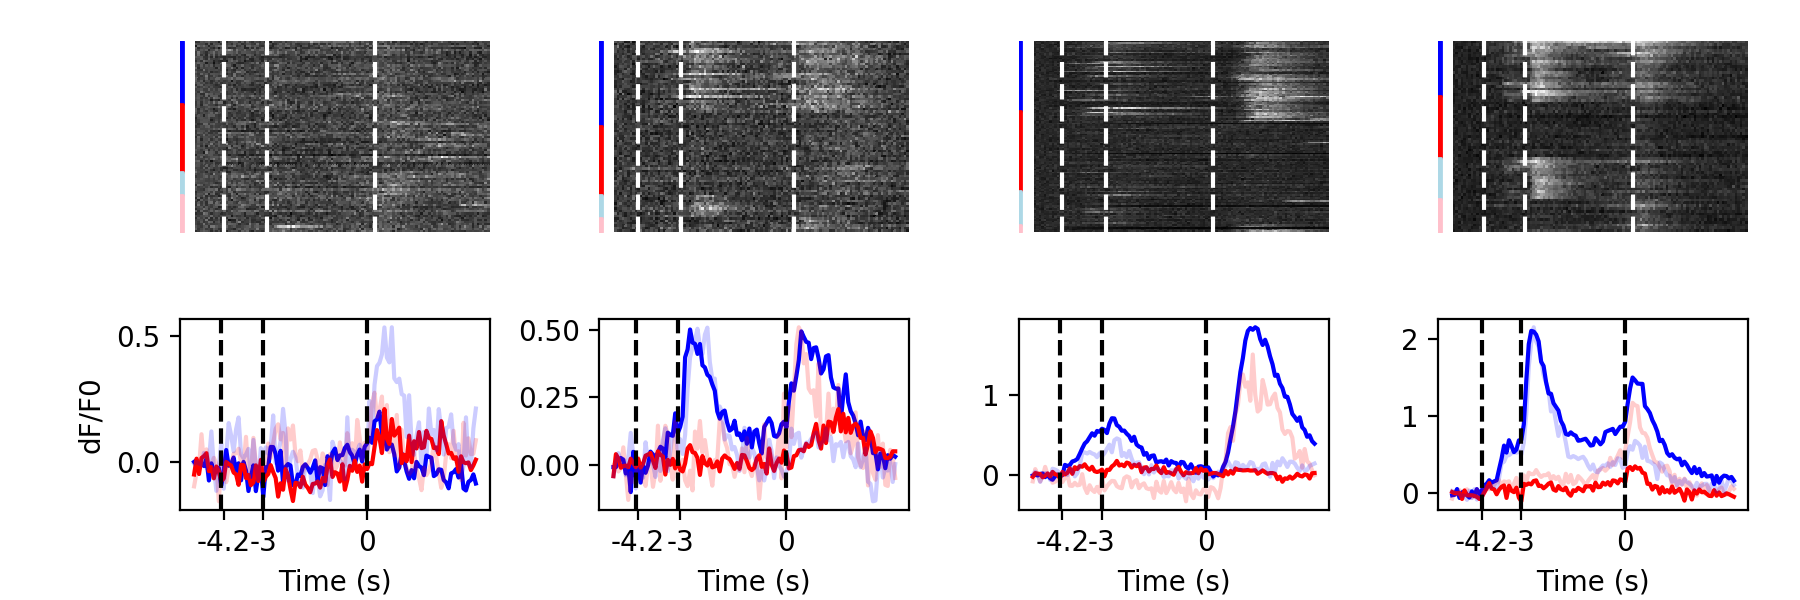

In [312]:
fig5b, axs = plt.subplots(2, 4, figsize = [9, 3])
fig5b.tight_layout()
fig5b.subplots_adjust(left=0.1, bottom=0.15)
example_cells = [
    {'subject_nickname': 'an041', 'session': 18, 'roi_idx': 17}, # idx 6562, 5B, 1
    {'subject_nickname': 'an043', 'session': 1, 'roi_idx': 11}, # idx 4352, 5B, 2
    {'subject_nickname': 'an041', 'session': 14, 'roi_idx': 6}, # idx 969, 5B, 3
    {'subject_nickname': 'an064', 'session': 18, 'roi_idx': 20}, # idx 12722, 5B, 4
]

for i, show_ylabel in zip([0, 1, 2, 3], [True, False, False, False]):
    plot_example_cell(example_cells[i], axs[0, i], axs[1, i], show_ylabel=show_ylabel)

## Figure 6 B-G

Spatial distribution of selective cells as a function of time within the trial.    

**Object location**: green  
**lick direction**: magenta  
**outcome**: cyan  
**mixed**: yellow  

The size of the marker indicates the strength of the respective effect size

In [162]:
depths_min = [100, 250, 400]
depths_max = [250, 400, 700]

frames = [25, 36, 50, 67, 75, 83]        

In [160]:
cells = imaging.Scan.Roi * imaging.RoiAnalyses & scans & 'inc=1'

panovas, alphas, betas, gammas, mus, ap_positions, ml_positions = [], [], [], [], [], [], []

for depth_min, depth_max in zip(depths_min, depths_max):
    scans = experiment.Session.ImagingDepth & 'imaging_depth between {} and {}'.format(depth_min, depth_max)
    cells = imaging.Scan.Roi * imaging.RoiAnalyses & scans & 'inc=1'
    panova, alpha, beta, gamma, mu, ap_pos, ml_pos = cells.fetch(
        'panova', 'alpha', 'beta', 'gamma', 'mu', 'ap_position', 'ml_position')
    panovas.append(panova)
    alphas.append(alpha)
    betas.append(beta)
    gammas.append(gamma)
    mus.append(mu)
    ap_positions.append(ap_pos)
    ml_positions.append(ml_pos)

<IPython.core.display.Javascript object>


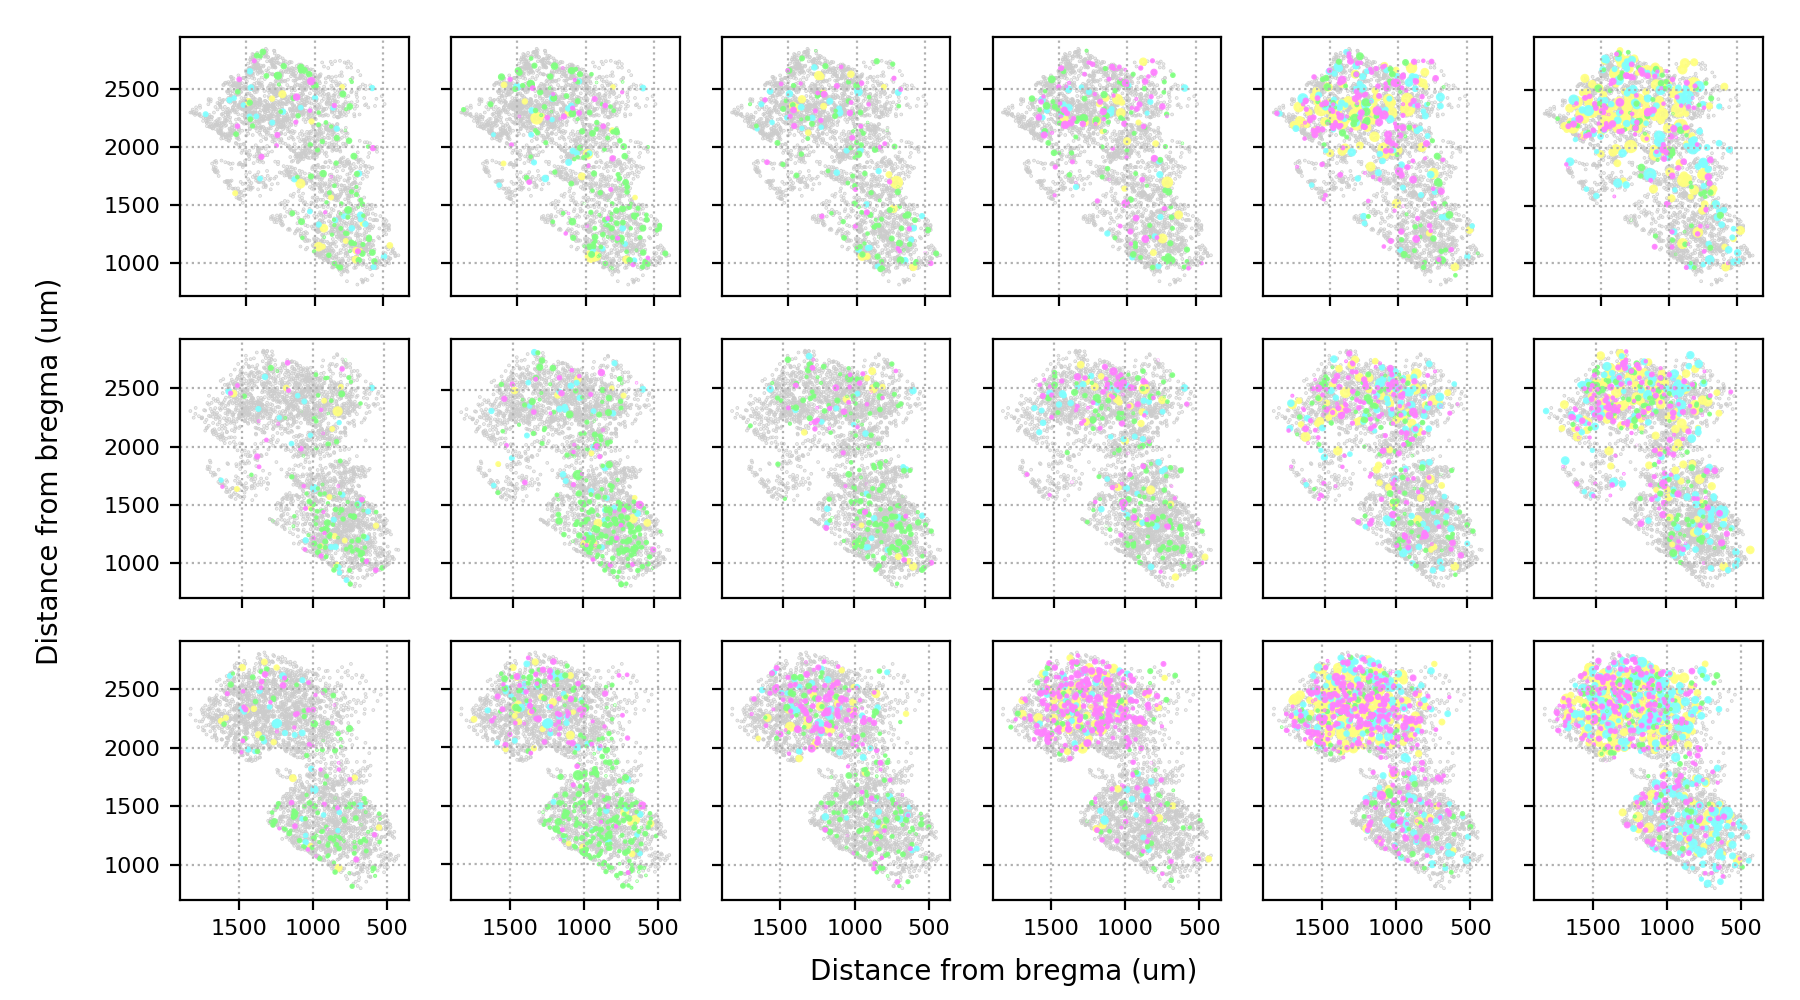

In [202]:
fig6, axs = plt.subplots(len(depths_min), len(frames), figsize=[9, 5])
for iax, axs_row in zip([0, 1, 2], axs):
    panova, alpha, beta, gamma, mu, ap_pos, ml_pos = \
        panovas[iax], alphas[iax], betas[iax], gammas[iax], mus[iax], ap_positions[iax], ml_positions[iax]
    for frame, ax in zip(frames, axs_row):
        a = np.array(alpha.tolist())[:, frame]
        b = np.array(beta.tolist())[:, frame]
        g = np.array(gamma.tolist())[:, frame]
        m = np.array(mu.tolist())[:, frame]
        p = np.array(panova.tolist())[:, frame, :]
        instruction = np.logical_and.reduce((p[:, 0] < 0.01, p[:, 1] > 0.01, p[:, 2] > 0.01))
        lick = np.logical_and.reduce((p[:, 0] > 0.01, p[:, 1] < 0.01, p[:, 2] > 0.01))
        outcome = np.logical_and.reduce((p[:, 0] > 0.01, p[:, 1] > 0.01, p[:, 2] < 0.01))
        compl = np.logical_or.reduce((
            np.logical_and(p[:, 0] < 0.01, p[:, 1] < 0.01),
            np.logical_and(p[:, 1] < 0.01, p[:, 2] < 0.01),
            np.logical_and(p[:, 0] < 0.01, p[:, 2] < 0.01)
        ))
        none = np.logical_not(np.logical_or.reduce((instruction, lick, outcome, compl)))
        colors = np.array([[0., 0., 0.]]*len(lick))
        sizes = np.array([0.] * len(lick))
        colors[instruction] = np.array([[0.5, 1, 0.5]]*sum(instruction))
        colors[lick] = np.array([[1, 0.5, 1]]*sum(lick))
        colors[outcome] = np.array([[0.5, 1, 1]]*sum(outcome))
        colors[compl] = np.array([[1, 1, 0.5]]*sum(compl))
        colors[none] = np.array([[0.8, 0.8, 0.8]]*sum(none))
        f = 8
        sizes[instruction] = np.abs(a[instruction]) * f
        sizes[lick] = np.abs(b[lick]) * f
        sizes[outcome] = np.abs(g[outcome]) * f
        sizes[compl] = np.max(np.array([np.abs(a[compl]), np.abs(b[compl]), np.abs(g[compl])]), axis=0) * f
        sizes[none] = 0.1
        if iax != 2:
            ax.set_xticklabels([])
        if frame != 25:
            ax.set_yticklabels([])
        ax.grid(linestyle=':')
        for i in [none, compl, outcome, instruction, lick]:
            ax.scatter(ml_pos[i], ap_pos[i], s=sizes[i], color=colors[i], alpha=0.9)
        ax.invert_xaxis()
        ax.tick_params(labelsize=8)
            
fig6.tight_layout()
fig6.text(0.45, 0.02, 'Distance from bregma (um)')
fig6.text(0.02, 0.7, 'Distance from bregma (um)', rotation=90)
plt.gcf().subplots_adjust(bottom=0.1, left=0.1)